# Learning LangGraph with BigQuery Agent

This notebook provides a hands-on introduction to LangGraph by building a BigQuery agent that queries data and creates visualisations.

## What You'll Learn

1. **LangGraph Fundamentals**: StateGraph, nodes, edges, and state management
2. **Tool Integration**: Building and using tools for agents
3. **Agent Orchestration**: Creating multi-step workflows
4. **BigQuery Integration**: Querying and analysing data
5. **Data Visualisation**: Automatically selecting and creating appropriate visualisations

## Architecture Overview

Our agent will follow this workflow:
```
User Query → Query Planner → BQ Executor → Data Analyser → Visualisation Generator → Response
```

## Part 1: LangGraph Basics

Let's start by understanding the core concepts of LangGraph.

In [19]:
# Import dependencies
import os
import operator
from typing import Annotated, TypedDict, Sequence
from google.cloud import bigquery
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Set up plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Dependencies imported successfully")
print(f"Project: {os.environ.get('GOOGLE_CLOUD_PROJECT', 'knowsee-platform-development')}")
print(f"Location: {os.environ.get('GOOGLE_CLOUD_LOCATION', 'europe-west2')}")

Dependencies imported successfully
Project: knowsee-platform-development
Location: europe-west2


### Understanding State in LangGraph

LangGraph uses a **state graph** where each node can read and modify shared state. The state is a typed dictionary that flows through the graph.

In [20]:
# Simple example: A state that tracks messages
class SimpleAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
# The Annotated[Sequence[BaseMessage], operator.add] means:
# - It's a sequence of messages
# - When updating, use operator.add to append (not replace)

print("State definition complete")

State definition complete


In [21]:
SimpleAgentState

__main__.SimpleAgentState

### Building Your First Graph

Let's create a simple graph with two nodes: one that greets and one that responds.

In [22]:
# Define node functions
def greeting_node(state: SimpleAgentState) -> SimpleAgentState:
    """First node: adds a greeting message"""
    return {
        "messages": [AIMessage(content="Hello! I'm your LangGraph agent.")]
    }

def response_node(state: SimpleAgentState) -> SimpleAgentState:
    """Second node: adds a response based on user input"""
    user_message = state["messages"][-1].content if state["messages"] else "nothing"
    return {
        "messages": [AIMessage(content=f"You said: {user_message}")]
    }

# Create the graph
simple_graph = StateGraph(SimpleAgentState)

# Add nodes
simple_graph.add_node("greet", greeting_node)
simple_graph.add_node("respond", response_node)

# Add edges (define the flow)
simple_graph.set_entry_point("greet")
simple_graph.add_edge("greet", "respond")
simple_graph.add_edge("respond", END)

# Compile the graph
simple_app = simple_graph.compile()

print("Simple graph created!")

Simple graph created!


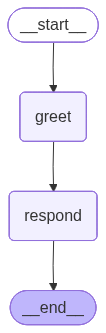

In [23]:
simple_app

In [24]:
# Test the simple graph
result = simple_app.invoke({
    "messages": [HumanMessage(content="I want to learn LangGraph")]
})

print("Messages in final state:")
for msg in result["messages"]:
    print(f"  {msg.__class__.__name__}: {msg.content}")

Messages in final state:
  HumanMessage: I want to learn LangGraph
  AIMessage: Hello! I'm your LangGraph agent.
  AIMessage: You said: Hello! I'm your LangGraph agent.


## Part 2: Setting Up BigQuery Connection

Before building our agent, let's connect to BigQuery and explore the public datasets.

In [25]:
# Set up BigQuery client
project_id = os.environ.get('GOOGLE_CLOUD_PROJECT', 'knowsee-platform-development')

bq_client = bigquery.Client(project=project_id)
print(f"BigQuery client initialised for project: {project_id}")

BigQuery client initialised for project: knowsee-platform-development


In [26]:
# Test query on a public dataset
test_query = """
SELECT 
  name, 
  SUM(number) as total_births
FROM `bigquery-public-data.usa_names.usa_1910_current`
WHERE year >= 2010
GROUP BY name
ORDER BY total_births DESC
LIMIT 10
"""

try:
    test_df = bq_client.query(test_query).to_dataframe()
    print("Connection successful! Top 10 names since 2010:")
    print(test_df)
except Exception as e:
    print(f"Error: {e}")

/opt/homebrew/Caskroom/miniconda/base/envs/platform/lib/python3.14/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Connection successful! Top 10 names since 2010:
       name  total_births
0      Emma        225940
1      Noah        221548
2    Olivia        219730
3      Liam        213851
4    Sophia        206500
5  Isabella        193709
6   William        184474
7       Ava        181625
8     Jacob        180680
9     Mason        177175


## Part 3: Building the BigQuery Agent

Now let's build a proper agent with tools and LLM integration.

### Define the Agent State

Our agent needs to track:
- Messages (conversation history)
- Query data (results from BQ)
- Analysis insights
- Visualisation recommendations

In [27]:
class BQAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    query_result: pd.DataFrame
    analysis: str
    visualisation_type: str
    user_query: str

### Create Tools for the Agent

Tools are functions that the LLM can call. We'll create:
1. A tool to execute BigQuery queries
2. A tool to analyse data
3. A tool to generate visualisations

In [28]:
@tool
def execute_bigquery(sql_query: str) -> str:
    """Execute a BigQuery SQL query and return results as a JSON string.
    
    Args:
        sql_query: The SQL query to execute
        
    Returns:
        JSON string containing query results
    """
    print("\n" + "="*80)
    print("EXECUTING SQL QUERY:")
    print("-"*80)
    print(sql_query)
    print("="*80 + "\n")
    
    try:
        query_job = bq_client.query(sql_query)
        df = query_job.to_dataframe()
        
        # Store in a way that can be retrieved later
        # For now, return summary info
        result_info = {
            "success": True,
            "row_count": len(df),
            "columns": df.columns.tolist(),
            "sample_data": df.head(3).to_dict('records'),
            "dtypes": df.dtypes.astype(str).to_dict()
        }
        
        print(f"✓ Query succeeded: {len(df)} rows returned\n")
        
        return str(result_info)
    except Exception as e:
        error_msg = f"Error executing query: {str(e)}"
        print(f"✗ {error_msg}\n")
        return error_msg

@tool
def list_available_datasets() -> str:
    """List some available public BigQuery datasets that can be queried.
    
    Returns:
        String describing available datasets
    """
    datasets = """
    Available public BigQuery datasets:
    
    1. bigquery-public-data.usa_names.usa_1910_current
       - US baby names from 1910 to present
       - Columns: state, gender, year, name, number
    
    2. bigquery-public-data.google_analytics_sample.ga_sessions_*
       - Google Analytics session data
       - Date range: 20160801 - 20170801
    
    3. bigquery-public-data.chicago_crime.crime
       - Chicago crime data
       - Columns: date, primary_type, description, location_description, arrest, etc.
    
    4. bigquery-public-data.samples.shakespeare
       - Shakespeare's works
       - Columns: word, word_count, corpus, corpus_date
    """
    return datasets

print("Tools defined successfully")

Tools defined successfully


### Initialise the LLM with Tools

In [29]:
# Initialise Gemini via Vertex AI
llm = ChatVertexAI(
    model="gemini-2.5-flash",
    temperature=0,
    project=os.environ.get('GOOGLE_CLOUD_PROJECT', 'knowsee-platform-development'),
    location=os.environ.get('GOOGLE_CLOUD_LOCATION', 'europe-west2'),
)

# Bind tools to the LLM
tools = [execute_bigquery, list_available_datasets]
llm_with_tools = llm.bind_tools(tools)

print("LLM initialised with tools via Vertex AI")
print(f"Model: gemini-2.5-flash")
print(f"Project: {llm.project}")
print(f"Location: {llm.location}")

LLM initialised with tools via Vertex AI
Model: gemini-2.5-flash
Project: knowsee-platform-development
Location: europe-west2


### Define Agent Nodes

Each node represents a step in our agent's workflow.

In [30]:
llm_with_tools

RunnableBinding(bound=ChatVertexAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True, 'structured_output': True}, project='knowsee-platform-development', location='europe-west2', model_name='gemini-2.5-flash', full_model_name='projects/knowsee-platform-development/locations/europe-west2/publishers/google/models/gemini-2.5-flash', client_options=ClientOptions: {'api_endpoint': 'europe-west2-aiplatform.googleapis.com', 'client_cert_source': None, 'client_encrypted_cert_source': None, 'quota_project_id': None, 'credentials_file': None, 'scopes': None, 'api_key': None, 'api_audience': None, 'universe_domain': None}, default_metadata=(), temperature=0.0, model_kwargs={}), kwargs={'tools': [{'type': '

In [ ]:
# What This Function Does

#   def should_continue(state: BQAgentState) -> str:
#       """Decide whether to continue with tools or end."""
#       messages = state["messages"]
#       last_message = messages[-1]

#       # If there are tool calls, continue to tools
#       if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
#           return "tools"
#       # Otherwise, end
#       return "end"

#   This function inspects the last message and returns either:
#   - "tools" → Go execute tools
#   - "end" → Stop, we're done

#   Breaking Down the Condition

#   Part 1: hasattr(last_message, 'tool_calls')

#   Safety check: Does this message object have a tool_calls attribute?

#   - HumanMessage → No tool_calls attribute
#   - ToolMessage → No tool_calls attribute
#   - AIMessage → Has tool_calls attribute (might be None or empty)

#   This prevents crashes if you accidentally check a message type that doesn't have this attribute.

#   Part 2: and last_message.tool_calls

#   Truthiness check: Is tool_calls not empty?

#   # These are "falsy" (would return "end"):
#   tool_calls = None        # LLM didn't want to call tools
#   tool_calls = []          # Empty list (no tools to call)

#   # These are "truthy" (would return "tools"):
#   tool_calls = [{'name': 'execute_bigquery', 'args': {...}}]

#   How This Creates the Loop

#   Remember your graph structure:

#   agent → should_continue → {tools: "tools", end: END}
#             ↑                    ↓
#             └────────────────────┘

#   Scenario 1: LLM wants to use a tool
#   # agent_node returns:
#   AIMessage(
#       content="",
#       tool_calls=[{'name': 'execute_bigquery', 'args': {...}}]
#   )

#   # should_continue checks:
#   hasattr(msg, 'tool_calls')  → True
#   msg.tool_calls              → [{'name': ...}]  (truthy!)

#   # Returns: "tools"
#   # Flow: agent → should_continue → tools → agent (loops back!)

#   Scenario 2: LLM provides final answer
#   # agent_node returns:
#   AIMessage(
#       content="The top 5 names are Emma, Olivia...",
#       tool_calls=None  # or []
#   )

#   # should_continue checks:
#   hasattr(msg, 'tool_calls')  → True
#   msg.tool_calls              → None (falsy!)

#   # Returns: "end"
#   # Flow: agent → should_continue → END (stops!)

#   Visual Example

#   Let me show you what happens with a real query:

#   User: "Get top 5 names in 2020"
#       ↓
#   [agent_node]
#       ↓
#   AIMessage(tool_calls=[{execute_bigquery}])  ← LLM: "I need data!"
#       ↓
#   [should_continue]
#       ↓
#   Check: tool_calls exists? YES → return "tools"
#       ↓
#   [ToolNode] executes SQL
#       ↓
#   ToolMessage(result="{'success': True, ...}")
#       ↓
#   [agent_node] ← Back to agent with results!
#       ↓
#   AIMessage(content="The top 5 names are...", tool_calls=None)  ← LLM: "I have the answer!"
#       ↓
#   [should_continue]
#       ↓
#   Check: tool_calls exists? None → return "end"
#       ↓
#   [END] ← Done!

#   Why Both Checks?

#   Why not just if last_message.tool_calls:?

#   Because this would crash if last_message doesn't have the attribute:

#   # Without hasattr:
#   human_msg = HumanMessage(content="Hello")
#   human_msg.tool_calls  # ← AttributeError: HumanMessage has no attribute 'tool_calls'

#   # With hasattr:
#   if hasattr(human_msg, 'tool_calls') and human_msg.tool_calls:
#       # Never gets here, safely returns False

#   ★ Insight ─────────────────────────────────────
#   Conditional Edges Are Routing Logic: In LangGraph, conditional edges are functions that return strings. Those strings map to
#    node names in your graph definition:

#   workflow.add_conditional_edges(
#       "agent",           # From this node
#       should_continue,   # Call this function
#       {
#           "tools": "tools",  # If returns "tools", go to "tools" node
#           "end": END         # If returns "end", stop
#       }
#   )

#   This is how you implement dynamic control flow in agents:
#   - Continue looping (tools → agent → tools)
#   - Exit when done (agent → END)
#   - Branch to different paths (could have "error", "human_review", etc.)

#   The LLM controls the flow by deciding whether to include tool_calls in its response!

In [31]:
# TODO(human)
# This is where you'll implement the agent's decision-making logic.
# The agent node should:
# 1. Take the current state and messages
# 2. Call the LLM to decide what to do next
# 3. Return updated state with the LLM's response
#
# Key considerations:
# - Should the agent call a tool or provide a final answer?
# - How do we pass conversation history to the LLM?
# - What information from state should be included?

def agent_node(state: BQAgentState) -> BQAgentState:
    """Main agent node that decides what to do next."""
    message = state["messages"]
    invocation = llm_with_tools.invoke(message) 
    return{
        "messages" : [invocation]
    } 

def should_continue(state: BQAgentState) -> str:
    """Decide whether to continue with tools or end."""
    messages = state["messages"]
    last_message = messages[-1]
    
    # If there are tool calls, continue to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    # Otherwise, end
    return "end"

### Build the Agent Graph

In [32]:
# Create the state graph
workflow = StateGraph(BQAgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)

# After tools, go back to agent
workflow.add_edge("tools", "agent")

# Compile
agent_app = workflow.compile()

print("Agent graph compiled successfully")

Agent graph compiled successfully


In [33]:
# Test the agent with detailed inspection
def run_agent(user_query: str, verbose: bool = True):
    """Run the agent with a user query."""
    initial_state = {
        "messages": [HumanMessage(content=user_query)],
        "user_query": user_query
    }
    
    result = agent_app.invoke(initial_state)
    
    print("\nAgent Response:")
    print("=" * 80)
    
    for i, msg in enumerate(result["messages"]):
        if isinstance(msg, HumanMessage):
            print(f"\n[{i}] User: {msg.content}")
            
        elif isinstance(msg, AIMessage):
            print(f"\n[{i}] Agent:")
            if msg.content:
                print(f"  Content: {msg.content}")
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                print(f"  Tool Calls:")
                for tool_call in msg.tool_calls:
                    print(f"    - {tool_call['name']}()")
                    if verbose:
                        print(f"      Args: {tool_call['args']}")
                        
        elif isinstance(msg, ToolMessage):
            print(f"\n[{i}] Tool Result ({msg.name}):")
            if verbose:
                # Pretty print the result
                result_preview = msg.content[:500] + "..." if len(msg.content) > 500 else msg.content
                print(f"  {result_preview}")
            else:
                print(f"  (length: {len(msg.content)} chars)")
    
    print("\n" + "=" * 80)
    
    return result

# Example 1: List datasets - simple test
print("TEST 1: Listing available datasets")
print("-" * 80)
result1 = run_agent("What datasets are available?")

In [34]:
# Example 2: Query data - this will show the SQL!
print("TEST 2: Running a query")
print("-" * 80)
result2 = run_agent(
    "Get the top 5 most common names in the USA names dataset for babies born in 2020"
)

# BONUS: Extract and display the SQL query from messages
print("\n\n" + "="*80)
print("EXTRACTING THE SQL QUERY FROM MESSAGES:")
print("="*80)
for msg in result2["messages"]:
    if isinstance(msg, AIMessage) and hasattr(msg, 'tool_calls') and msg.tool_calls:
        for tool_call in msg.tool_calls:
            if tool_call['name'] == 'execute_bigquery':
                sql = tool_call['args'].get('sql_query', '')
                print("\nThe LLM generated this SQL:")
                print("-"*80)
                print(sql)
                print("-"*80)

TEST 2: Running a query
--------------------------------------------------------------------------------

EXECUTING SQL QUERY:
--------------------------------------------------------------------------------
SELECT name, SUM(number) AS total_babies FROM `bigquery-public-data.usa_names.usa_1910_current` WHERE year = 2020 GROUP BY name ORDER BY total_babies DESC LIMIT 5



/opt/homebrew/Caskroom/miniconda/base/envs/platform/lib/python3.14/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✓ Query succeeded: 5 rows returned


Agent Response:

[0] User: Get the top 5 most common names in the USA names dataset for babies born in 2020

[1] Agent:
  Tool Calls:
    - execute_bigquery()
      Args: {'sql_query': 'SELECT name, SUM(number) AS total_babies FROM `bigquery-public-data.usa_names.usa_1910_current` WHERE year = 2020 GROUP BY name ORDER BY total_babies DESC LIMIT 5'}

[2] Tool Result (execute_bigquery):
  {'success': True, 'row_count': 5, 'columns': ['name', 'total_babies'], 'sample_data': [{'name': 'Liam', 'total_babies': 19777}, {'name': 'Noah', 'total_babies': 18630}, {'name': 'Olivia', 'total_babies': 17641}], 'dtypes': {'name': 'object', 'total_babies': 'Int64'}}

[3] Agent:
  Content: The top 5 most common names in the USA for babies born in 2020 are:

1. Liam (19777 babies)
2. Noah (18630 babies)
3. Olivia (17641 babies)
4. Oliver (14601 babies)
5. Elijah (13912 babies)



EXTRACTING THE SQL QUERY FROM MESSAGES:

The LLM generated this SQL:
--------------------

 <!-- The Flow of Information

  Let me trace exactly what happens when you run run_agent("Get top 5 names in 2020"):

  Step 1: User Message Goes In

  initial_state = {
      "messages": [HumanMessage(content="Get top 5 names in 2020")]
  }

  Step 2: Agent Node Processes It

  Your agent_node function does this:
  def agent_node(state: BQAgentState) -> BQAgentState:
      messages = state["messages"]  # Gets [HumanMessage("Get top 5...")]
      response = llm_with_tools.invoke(messages)  # Calls Gemini
      return {"messages": [response]}  # Returns the LLM's response

  Step 3: What the LLM Returns

  The LLM doesn't return plain text. It returns an AIMessage object that looks like this:

  AIMessage(
      content="",  # Empty because it wants to call a tool first
      tool_calls=[
          {
              'name': 'execute_bigquery',
              'id': 'call_abc123',
              'args': {
                  'sql_query': 'SELECT name, SUM(number) as total FROM ...'
              }
          }
      ]
  )

  Key insight: The SQL query is inside tool_calls[0]['args']['sql_query']!

  Step 4: The Router Checks

  def should_continue(state: BQAgentState) -> str:
      last_message = messages[-1]
      if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
          return "tools"  # ← Goes here because tool_calls exists!

  Step 5: ToolNode Executes

  The ToolNode does this automatically:
  1. Reads the tool_calls from the AIMessage
  2. Finds the function named execute_bigquery
  3. Calls it: execute_bigquery(sql_query='SELECT ...')
  4. Returns a ToolMessage with the result

  Step 6: My Two Methods to Show You the SQL

  Method 1: Print inside the tool
  @tool
  def execute_bigquery(sql_query: str) -> str:
      print("EXECUTING SQL QUERY:")
      print(sql_query)  # ← Prints when the function runs!
      # ... rest of code

  This prints the SQL while the tool is executing.

  Method 2: Extract from messages afterwards
  for msg in result2["messages"]:
      if isinstance(msg, AIMessage) and msg.tool_calls:
          for tool_call in msg.tool_calls:
              if tool_call['name'] == 'execute_bigquery':
                  sql = tool_call['args']['sql_query']  # ← Extract it!
                  print(sql)

  This reads the SQL from the message history after everything is done.

  Visual Diagram

  User Query
      ↓
  agent_node → LLM → AIMessage(tool_calls=[{name: 'execute_bigquery', args: {sql_query: 'SELECT...'}}])
      ↓
  should_continue → sees tool_calls → routes to "tools"
      ↓
  ToolNode → extracts args → execute_bigquery(sql_query='SELECT...')
      ↓                              ↓
      ↓                         print(sql_query) ← Method 1: You see it here!
      ↓
  ToolMessage(result) → back to agent_node → LLM sees result → final answer
      ↓
  result["messages"] ← Contains full history
      ↓
  Extract tool_calls['args']['sql_query'] ← Method 2: You see it here!

  Why This Is Powerful

  Everything is stored in messages! The message list is like a complete audit log:

  result["messages"] = [
      HumanMessage("Get top 5..."),           # [0] Your question
      AIMessage(tool_calls=[...]),            # [1] LLM decides to call tool
      ToolMessage(content="..."),             # [2] Tool execution result
      AIMessage(content="The top 5 are...")   # [3] LLM's final answer
  ]

  You can inspect ANY part of this afterwards. The SQL is in messages[1].tool_calls[0]['args']['sql_query'].

  ★ Insight ─────────────────────────────────────
  Messages Are the Source of Truth: LangGraph's message-based architecture means every decision, every tool call, and every
  result is explicitly stored. This is fundamentally different from traditional function calls where intermediate steps are
  hidden. You can:
  - Debug by inspecting message history
  - Implement retry logic by modifying messages
  - Build human-in-the-loop by pausing and editing messages
  - Create branching logic based on message content
  - Log everything for observability

  The "magic" is just structured data passing through a graph! -->

In [35]:
# Example 1: List datasets
result1 = run_agent("What datasets are available?")


Agent Response:

[0] User: What datasets are available?

[1] Agent:
  Tool Calls:
    - list_available_datasets()
      Args: {}

[2] Tool Result (list_available_datasets):
  
    Available public BigQuery datasets:

    1. bigquery-public-data.usa_names.usa_1910_current
       - US baby names from 1910 to present
       - Columns: state, gender, year, name, number

    2. bigquery-public-data.google_analytics_sample.ga_sessions_*
       - Google Analytics session data
       - Date range: 20160801 - 20170801

    3. bigquery-public-data.chicago_crime.crime
       - Chicago crime data
       - Columns: date, primary_type, description, location_description, arrest, et...

[3] Agent:
  Content: The following public BigQuery datasets are available:

1.  **bigquery-public-data.usa_names.usa_1910_current**
    *   US baby names from 1910 to present
    *   Columns: state, gender, year, name, number

2.  **bigquery-public-data.google_analytics_sample.ga_sessions_\***
    *   Google Analytic

In [36]:
# Example 2: Query data
result2 = run_agent(
    "Get the top 5 most common names in the USA names dataset for babies born in 2020"
)


EXECUTING SQL QUERY:
--------------------------------------------------------------------------------
SELECT name, SUM(number) AS total_babies FROM `bigquery-public-data.usa_names.usa_1910_current` WHERE year = 2020 GROUP BY name ORDER BY total_babies DESC LIMIT 5



/opt/homebrew/Caskroom/miniconda/base/envs/platform/lib/python3.14/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✓ Query succeeded: 5 rows returned


Agent Response:

[0] User: Get the top 5 most common names in the USA names dataset for babies born in 2020

[1] Agent:
  Tool Calls:
    - list_available_datasets()
      Args: {}

[2] Tool Result (list_available_datasets):
  
    Available public BigQuery datasets:

    1. bigquery-public-data.usa_names.usa_1910_current
       - US baby names from 1910 to present
       - Columns: state, gender, year, name, number

    2. bigquery-public-data.google_analytics_sample.ga_sessions_*
       - Google Analytics session data
       - Date range: 20160801 - 20170801

    3. bigquery-public-data.chicago_crime.crime
       - Chicago crime data
       - Columns: date, primary_type, description, location_description, arrest, et...

[3] Agent:
  Tool Calls:
    - execute_bigquery()
      Args: {'sql_query': 'SELECT name, SUM(number) AS total_babies FROM `bigquery-public-data.usa_names.usa_1910_current` WHERE year = 2020 GROUP BY name ORDER BY total_babies DESC

## Part 5: Adding Data Analysis and Visualisation

Now let's extend our agent to analyse query results and create visualisations.

In [37]:
# Enhanced state with visualisation tracking
class EnhancedBQAgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    query_result_df: object  # Store actual DataFrame
    analysis: str
    visualisation_config: dict
    user_query: str

In [ ]:
# TODO(human)
# Implement a function to automatically select the best visualisation type.
# This function should:
# 1. Analyse the DataFrame (number of columns, data types, row count)
# 2. Determine if it's time-series, categorical, numerical, etc.
# 3. Return a recommended visualisation type and configuration
#
# Consider these visualisation types:
# - bar chart: for categorical comparisons
# - line chart: for time-series data
# - scatter plot: for correlation between two numerical variables
# - histogram: for distribution of single numerical variable
# - pie chart: for part-to-whole relationships (use sparingly)

def select_visualisation_type(df: pd.DataFrame, user_query: str) -> dict:
    """Analyse DataFrame and select appropriate visualisation.
    
    Args:
        df: The DataFrame to visualise
        user_query: The original user query for context
        
    Returns:
        Dictionary with visualisation configuration
    """
    
    # Step 1: Gather information about the DataFrame
    num_columns = len(df.columns)
    column_names = df.columns.tolist()
    dtypes = df.dtypes.to_dict()

    # Step 2: Check for time-series indicators
    time_columns = [col for col in column_names if col in ['year', 'date', 'time', 'month']]

    # Step 3: Identify numerical vs categorical columns
    numerical_cols = [col for col, dtype in dtypes.items() if dtype in ['int64', 'float64']]
    categorical_cols = [col for col, dtype in dtypes.items() if dtype == 'object']

      # Step 4: Decision logic - YOU IMPLEMENT THIS!
      # Questions to answer:
      # - If there's a 'year' column + numerical column → line chart?
      # - If there's only categorical + numerical → bar chart?
      # - If there are 2 numerical columns → scatter plot?

    # TODO: Your logic here!

    return config

In [ ]:
def create_visualisation(df: pd.DataFrame, config: dict):
    """Create a visualisation based on the configuration."""
    viz_type = config.get('type', 'bar')
    
    if viz_type == 'bar':
        fig = px.bar(
            df,
            x=config.get('x'),
            y=config.get('y'),
            title=config.get('title', 'Bar Chart'),
            color=config.get('color')
        )
    elif viz_type == 'line':
        fig = px.line(
            df,
            x=config.get('x'),
            y=config.get('y'),
            title=config.get('title', 'Line Chart'),
            color=config.get('color')
        )
    elif viz_type == 'scatter':
        fig = px.scatter(
            df,
            x=config.get('x'),
            y=config.get('y'),
            title=config.get('title', 'Scatter Plot'),
            color=config.get('color'),
            size=config.get('size')
        )
    elif viz_type == 'histogram':
        fig = px.histogram(
            df,
            x=config.get('x'),
            title=config.get('title', 'Histogram')
        )
    else:
        # Default to bar chart
        fig = px.bar(df, title='Data Visualisation')
    
    fig.update_layout(
        template='plotly_white',
        height=500,
        showlegend=True
    )
    
    return fig

## Part 6: Putting It All Together

Let's create a complete workflow that queries, analyses, and visualises data.

In [ ]:
def complete_bq_workflow(user_query: str):
    """Complete workflow: query -> analyse -> visualise."""
    
    print(f"Processing: {user_query}")
    print("="*80)
    
    # Step 1: Run agent to get query results
    print("\nStep 1: Running agent to execute query...")
    result = run_agent(user_query)
    
    # Extract query result if available
    # This is a simplified version - you'd need to enhance the agent
    # to properly store DataFrame in state
    
    # For demonstration, let's run a sample query directly
    sample_query = """
    SELECT 
        year,
        name,
        SUM(number) as total_births
    FROM `bigquery-public-data.usa_names.usa_1910_current`
    WHERE name IN ('Emma', 'Olivia', 'Liam', 'Noah')
    AND year >= 2010
    GROUP BY year, name
    ORDER BY year, total_births DESC
    """
    
    print("\nStep 2: Fetching data...")
    df = bq_client.query(sample_query).to_dataframe()
    print(f"Retrieved {len(df)} rows")
    print(df.head())
    
    # Step 2: Analyse the data
    print("\nStep 3: Analysing data...")
    analysis = f"""
    Data Summary:
    - Total rows: {len(df)}
    - Columns: {', '.join(df.columns)}
    - Year range: {df['year'].min()} to {df['year'].max()}
    - Names analysed: {', '.join(df['name'].unique())}
    """
    print(analysis)
    
    # Step 3: Select and create visualisation
    print("\nStep 4: Creating visualisation...")
    viz_config = {
        'type': 'line',
        'x': 'year',
        'y': 'total_births',
        'color': 'name',
        'title': 'Name Popularity Trends (2010-Present)'
    }
    
    fig = create_visualisation(df, viz_config)
    fig.show()
    
    print("\n" + "="*80)
    print("Workflow complete!")
    
    return df, analysis, fig

In [ ]:
# Run the complete workflow
df, analysis, fig = complete_bq_workflow(
    "Show me the popularity trends for names Emma, Olivia, Liam, and Noah since 2010"
)

## Part 7: Exercises and Challenges

Now it's your turn to enhance the agent! Try these challenges:

### Challenge 1: Implement the agent_node function
Go back to the `agent_node` function and implement the logic to:
- Call the LLM with current state
- Handle tool calls appropriately
- Return updated state

### Challenge 2: Implement visualisation selection
Complete the `select_visualisation_type` function to automatically choose the best chart type based on data characteristics.

### Challenge 3: Add more tools
Create additional tools:
- `summarise_data`: Generate statistical summary of query results
- `compare_queries`: Run multiple queries and compare results
- `export_results`: Save results to different formats (CSV, JSON, etc.)

### Challenge 4: Add conversation memory
Enhance the agent to remember previous queries and allow follow-up questions like:
- "Show me the same data but for California only"
- "Now create a bar chart instead"

### Challenge 5: Error handling and validation
Add robust error handling:
- Validate SQL queries before execution
- Handle empty result sets gracefully
- Provide helpful error messages

## Additional Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [BigQuery Public Datasets](https://cloud.google.com/bigquery/public-data)
- [Plotly Documentation](https://plotly.com/python/)
- [LangChain Tools](https://python.langchain.com/docs/modules/agents/tools/)

## Summary

Congratulations! You've learned:

1. **LangGraph Fundamentals**: How to create state graphs with nodes and edges
2. **Tool Integration**: How to bind tools to LLMs and create tool nodes
3. **Agent Orchestration**: How to build conditional workflows that make decisions
4. **BigQuery Integration**: How to query and process data from BQ
5. **Data Visualisation**: How to automatically select and create appropriate visualisations

The key insight is that LangGraph separates **what** (state) from **how** (nodes) and **when** (edges), making complex agent workflows manageable and debuggable.